#### This note book implements Gaussian Process emulator for the data from a Social Force Model.
The data must be located in the data folder


In [148]:
import os
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
import matplotlib.pyplot as plt
#from gp_emulator import GaussianProcess
from GaussianProcess_mogp import GaussianProcess

os.chdir("/Users/MinhKieu/Documents/Research/Emulator_ABM")  #Mac
print("checked")


checked


In [149]:
# define RMSE
def rmse(dataset1, dataset2, ignore=None):

   # Make sure that the provided data sets are numpy ndarrays, if not
   # convert them and flatten te data sets for analysis
   if type(dataset1).__module__ != np.__name__:
      d1 = np.asarray(dataset1).flatten()
   else:
      d1 = dataset1.flatten()

   if type(dataset2).__module__ != np.__name__:
      d2 = np.asarray(dataset2).flatten()
   else:
      d2 = dataset2.flatten()

   # Make sure that the provided data sets are the same size
   if d1.size != d2.size:
      raise ValueError('Provided datasets must have the same size/shape')

   # Check if the provided data sets are identical, and if so, return 0
   # for the root-mean-squared error
   if np.array_equal(d1, d2):
      return 0

   # If specified, remove the values to ignore from the analysis and compute
   # the element-wise difference between the data sets
   if ignore is not None:
      index = np.intersect1d(np.where(d1 != ignore)[0], 
                                np.where(d2 != ignore)[0])
      error = d1[index].astype(np.float64) - d2[index].astype(np.float64)
   else:
      error = d1.astype(np.float64) - d2.astype(np.float64)

   # Compute the mean-squared error
   meanSquaredError = np.sum(error**2) / error.size

   # Return the root of the mean-square error
   return np.sqrt(meanSquaredError)

In [150]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Narrow corridor, Stable demand, Train on Demand = 2,4,6pedestrian/2s, then test on Demand = 2,3,4,5,6,7 pedestrian/2s

Longer term prediction: We take the counts when time = 120s, then predict the final crowding at the end of the period

We train the Emulator with data where demand varies from 2 to 7

And then we give a new data when demand = 3 for testing

(Emulator should do very well in this case)



In [151]:
#load simulated training data:
data = np.genfromtxt('./data/agg-1-3-5.csv', delimiter=',')
#data = data[data[:,0]>100]
#x: Time, count_gate x 9 (10 columns)
#y: mean_speed,std_speed,mean_xforce,std_xforce  (4 columns)


In [152]:
def create_average(y_train):
    y_train_final = list()
    #creates array for average values
    for i,d in enumerate(y_train):
        if ((i+1) % 3) == 0:
            #print(i)
            avg_y_train = np.mean(y_train[i - 2:(i+1)])
            if np.isnan(avg_y_train):
                print(y_train[i - 3:i])
            #print(avg_y_train)
            y_train_final.append(avg_y_train)
    return y_train_final

In [153]:
## process data to make predictions: X= Xt, Y = [Speed,Social Force]
x_train = data[data[:,0]==60,]
x_train = x_train[:,(1,3,5,7,9,11,13,15,17)]

y_train=(data[data[:,0]>240,19])

y_train_final = create_average(y_train)

print(y_train_final)
#print(y_test[:5])

[0.12366666666666666, 0.16666666666666666, 0.17166666666666666, 0.050333333333333334, 0.11599999999999999, 0.05033333333333334, 0.12033333333333333, 0.044333333333333336, 0.16933333333333334]


In [154]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
#sc.fit(X_train)
#X_train = sc.transform(x_train)
X_train = sc.fit_transform(x_train)


In [155]:
#Emulator: Gaussian Process Regression  
gp2 = GaussianProcess(X_train,y_train_final)
gp2.learn_hyperparameters(n_tries=4)

(-33.449100880438046,
 array([-21.031, -7.864, -3.223, -27.271, -3.264, -7.204, -30.842, -10.256,
        -31.150, -3.564]))

In [156]:
y_pred, y_unc, _ = gp2.predict(X_train,do_unc=True, do_deriv=True)
print(y_pred)

[0.124 0.167 0.172 0.050 0.116 0.050 0.120 0.044 0.169]


In [157]:
# Main modelling block

pred_results = list()
y_test_list = list()
x_test_list = list()
for i in range(1,10):
    #load testing data
    #print(i)
    filename = './data/val-'+ str(i) +'ped.csv'
    #print(filename)
    test_data = np.genfromtxt(filename, delimiter=',')
    #print(test_data)
    #test_data = test_data[test_data[:,0]>100]
    #x: flow in at each `check point', or `cell': x_i^t
    #y: mean_speed,std_speed,mean_xforce,std_xforce
    x_test = test_data[test_data[:,0]==60,]
    x_test = x_test[:,(1,3,5,7,9,11,13,15,17)]
    X_test = sc.transform(x_test)
    #print(x_test[0])
    #x_test_list.append(x_test[0])
    
    #print(x_test_list)
    y_test=np.mean(test_data[test_data[:,0]>240,19])
    y_test_list.append(y_test)
    
    y_pred, y_unc, _= gp2.predict(X_test,do_unc=False, do_deriv=False)
    pred_results.append(y_pred[0])
 
    #print(y_unc)
    #print(y_pred)
    #pred_results.append(y_pred)
#print(x_test_list)
print(y_test_list)
print(pred_results)


[0.04699999999999999, 0.09299999999999999, 0.11699999999999999, 0.1386666666666667, 0.16733333333333333, 0.18866666666666668, 0.19366666666666665, 0.22966666666666669, 0.24633333333333332]
[0.04830628926977454, 0.08427027496964712, 0.11164715407527837, 0.14772342231591296, 0.15717535067631871, 0.19418267685634305, 0.2146267174028509, 0.21851511055971606, 0.2215516991785762]


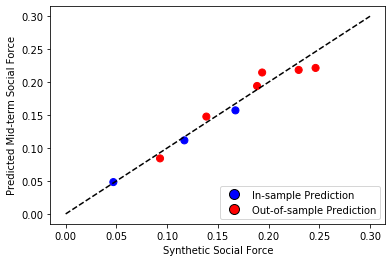

In [158]:
# Plot predicted MPG without error bars
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='None', label='In-sample Prediction',
                          markerfacecolor='b', markersize=10),
                   Line2D([0], [0], marker='o', color='None', label='Out-of-sample Prediction',
                          markerfacecolor='r', markersize=10)]

y = ['b','r','b','r','b','r','r','r','r']

plt.scatter(y_test_list, pred_results, c=y, s=50)
plt.legend(handles=legend_elements, loc='lower right')
plt.plot([0, 0.3], [0, 0.3], 'k--')
plt.xlabel('Synthetic Social Force')
plt.ylabel('Predicted Mid-term Social Force')
#plt.savefig('NHPP_aggregated_same.pdf')
plt.savefig('Figures/Mid-term-GP.pdf')
plt.show()

In [159]:
print('Mean Absolute Percentage Error:', mape(pred_results,y_test_list))
#print('Mean Absolute Percentage Error:', mape(y_test_list,pred_results))
print('Root Mean Squared Error:', rmse(pred_results,y_test_list))

Mean Absolute Percentage Error: 6.594088539866291
Root Mean Squared Error: 0.01291000290502073


## Narrow corridor, Stable demand, Train on Demand = 1,3,5pedestrian/s, then test on Demand = 1 to 9/s

Short-term prediction: We try to predict the next minute

In [160]:
minT = 45
maxT = 285
timeStep = 15

#load simulated training data: #switch better same and narrow experiment
data = np.genfromtxt('./data/agg-1-3-5.csv', delimiter=',')
data = data[data[:,0]>minT]
#x: Time, count_gate x 9 (10 columns)
#y: mean_speed,std_speed,mean_xforce,std_xforce  (4 columns)




In [161]:
## process data to make predictions: X= Xt, Y = [Speed,Social Force]
x_train = data[:-1,(0,1,3,5,7,9,11,13,15,17)]

y_train=data[1:,19]


In [162]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
#sc.fit(X_train)
#X_train = sc.transform(x_train)
X_train = sc.fit_transform(x_train)

In [163]:
#Emulator: Gaussian Process Regression  
gp2 = GaussianProcess(X_train,y_train)
gp2.learn_hyperparameters(n_tries=50)

(-305.36171899524425,
 array([1.285, -14.807, -46.801, -94.088, 1.664, -0.252, -43.114, -2.406,
        0.816, -1.570, -4.827]))

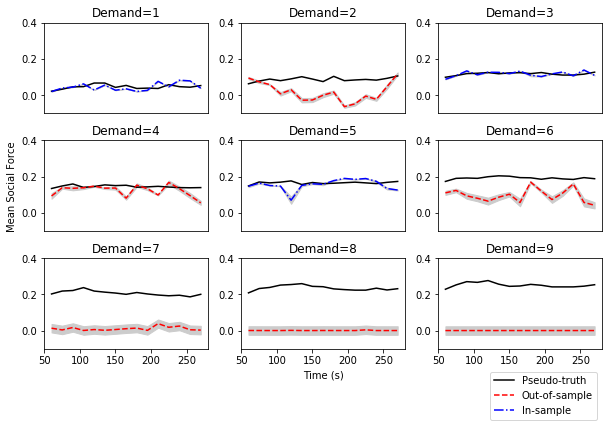

In [168]:
# Main modelling block
fig, axs = plt.subplots(3,3, figsize=(10, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.2)

custom_lines = [Line2D([0], [0], color='k'),
                Line2D([0], [0], color='r', ls = '--'),
                Line2D([0], [0], color='b', ls = '-.')]

axs = axs.ravel()
#import forestci as fci
pred_results = []
y_test_list = []
for i in range(1,10):
    #load testing data
    #print(i)
    filename = './data/val-'+ str(i) +'ped.csv'
    #print(filename)
    test_data = np.genfromtxt(filename, delimiter=',')
    #print(test_data)
    test_data = test_data[test_data[:,0]>minT]
    #x: flow in at each `check point', or `cell': x_i^t
    #y: mean_speed,std_speed,mean_xforce,std_xforce
    x_test = test_data[:-1,(0,1,3,5,7,9,11,13,15,17)]
    X_test = sc.transform(x_test)
    y_test=test_data[1:,19]
    
    #make predictions using the trained model
    y_pred, y_unc, _ = gp2.predict(X_test,do_unc=True, do_deriv=False)
    #plotting
    
    axs[i-1].plot(range(minT+timeStep,maxT,timeStep),y_test,'k-',label='Testing data')
    axs[i-1].set_title('Demand='+ str(i))
    axs[i-1].fill_between(range(minT+timeStep,maxT,timeStep), y_pred-2.96*y_unc,y_pred+2.96*y_unc, color="0.8")
    
    if (i<7):
        axs[i-1].get_xaxis().set_visible(False)
    if (i==1):
        #axs[i-1].set_ylim(-0.1, 0.1)
        axs[i-1].plot(range(minT+timeStep,maxT,timeStep),y_pred,'b-.',label='In-sample ')
        #legend = axs[i-1].legend(loc='upper right')        
    if (i==2):
        #axs[i-1].set_ylim(-0.1, 0.1)
        axs[i-1].plot(range(minT+timeStep,maxT,timeStep),y_pred,'r--',label='Out-of-sample ')
        #legend = axs[i-1].legend(loc='upper right')
    if (i==3):
        #axs[i-1].set_ylim(-0.1, 0.1)
        axs[i-1].plot(range(minT+timeStep,maxT,timeStep),y_pred,'b-.',label='In-sample ')
    if (i==4):
        #axs[i-1].set_ylim(-0.1, 0.1)
        axs[i-1].plot(range(minT+timeStep,maxT,timeStep),y_pred,'r--',label='Out-of-sample ')
        #legend = axs[i-1].legend(loc='lower right')
        axs[i-1].set_ylabel('Mean Social Force')
        
    if (i==5):
        #axs[i-1].set_ylim(-0.1, 0.1)
        axs[i-1].plot(range(minT+timeStep,maxT,timeStep),y_pred,'b-.',label='In-sample ')
    if (i>=6):
        #axs[i-1].set_ylim(-0.1, 0.1)
        axs[i-1].plot(range(minT+timeStep,maxT,timeStep),y_pred,'r--',label='Out-of-sample ')
        
    if (i==8):
        axs[i-1].set_xlabel('Time (s)')
        axs[-1].legend(custom_lines, ['Pseudo-truth', 'Out-of-sample', 'In-sample'],bbox_to_anchor=(1, -0.2))
        #legend = axs[i-1].legend(loc='lower outside')
                
    axs[i-1].set_ylim(-0.1, 0.4)
    #Save to the overall storage
    pred_results.append(y_pred)
    y_test_list.append(y_test)

pred_results=np.hstack(pred_results)
y_test_list=np.hstack(y_test_list)

plt.savefig('Figures/Short-term-GP-less-training.pdf')
plt.show()    
#print(pred_results)
#print(y_test_list)

In [169]:
def mape2(y_pred,y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('Mean Absolute Percentage Error v2:', mape2(y_test_list,pred_results))

print('Mean Absolute Percentage Error:', mape(y_test_list,pred_results))
print('Root Mean Squared Error:', rmse(pred_results,y_test_list))

Mean Absolute Percentage Error v2: 6644800182.910015
Mean Absolute Percentage Error: 57.15237477560833
Root Mean Squared Error: 0.14064917250229508


### SCATTER PLOT!
#### Narrow corridor, Stable demand, Train on Demand = 2,4,6pedestrian/2s, then test on Demand = 2,3,4,5,6,7 pedestrian/2s 

Multiple Outputs: Social Force at each cell

Short-term prediction: We try to predict the next minute

Take some blocks from above, the difference is only at the main modelling block


In [170]:
# Main modelling block
#import forestci as fci
pred_results_SEEN = []
y_test_list_SEEN = []
for i in range(1,7,2):
    #load testing data
    #print(i)
    filename = './data/val-'+ str(i) +'ped.csv'
    #print(filename)
    test_data = np.genfromtxt(filename, delimiter=',')
    #print(test_data)
    test_data = test_data[test_data[:,0]>minT]
    #x: flow in at each `check point', or `cell': x_i^t
    #y: mean_speed,std_speed,mean_xforce,std_xforce
    x_test = test_data[:-1,(0,1,3,5,7,9,11,13,15,17)]
    X_test = sc.transform(x_test)
    y_test=test_data[1:,19]
    
    #make predictions using the trained model
    y_pred, y_unc, _ = gp2.predict(X_test,do_unc=True, do_deriv=False)
    pred_results_SEEN.append(y_pred)
    y_test_list_SEEN.append(y_test) 

#pred_results_SEEN=np.hstack(pred_results_SEEN)
#y_test_list_SEEN = np.hstack(y_test_list_SEEN)


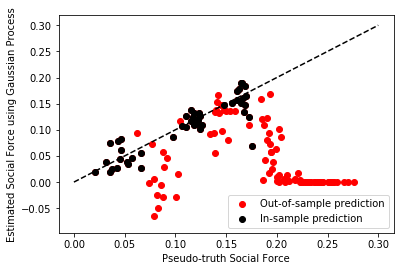

In [172]:

# Plot predicted MPG without error bars
plt.scatter(y_test_list, pred_results,c='red',label='Out-of-sample prediction')

plt.scatter(y_test_list_SEEN, pred_results_SEEN,c='black',label='In-sample prediction')


plt.plot([0, 0.3], [0, 0.3], 'k--')
plt.legend(loc='lower right')
plt.xlabel('Pseudo-truth Social Force')
plt.ylabel('Estimated Social Force using Gaussian Process')
#plt.savefig('NHPP_aggregated_same.pdf')
plt.savefig('Figures/Short-term-GP-less-training-scatterplot.pdf')
plt.show()

### Now train with Demand = 1,3,5,7,9 and test with demand = 1 to 9

In [173]:
minT = 45
maxT = 285
timeStep = 15

#load simulated training data: #switch better same and narrow experiment
data = np.genfromtxt('./data/agg-1-3-5-7-9.csv', delimiter=',')
data = data[data[:,0]>minT]
#x: Time, count_gate x 9 (10 columns)
#y: mean_speed,std_speed,mean_xforce,std_xforce  (4 columns)

## process data to make predictions: X= Xt, Y = [Speed,Social Force]
x_train = data[:-1,(0,1,3,5,7,9,11,13,15,17)]

y_train=data[1:,19]


In [174]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
#sc.fit(X_train)
#X_train = sc.transform(x_train)
X_train = sc.fit_transform(x_train)
#Emulator: Gaussian Process Regression  
gp2 = GaussianProcess(X_train,y_train)
gp2.learn_hyperparameters(n_tries=100)


Overflow in optimization routine, skipping this iteration


(-459.1505148817908,
 array([2.032, -20.827, -1.707, -0.335, -0.314, -1.874, -2.119, -4.345,
        -0.842, -0.326, -3.769]))

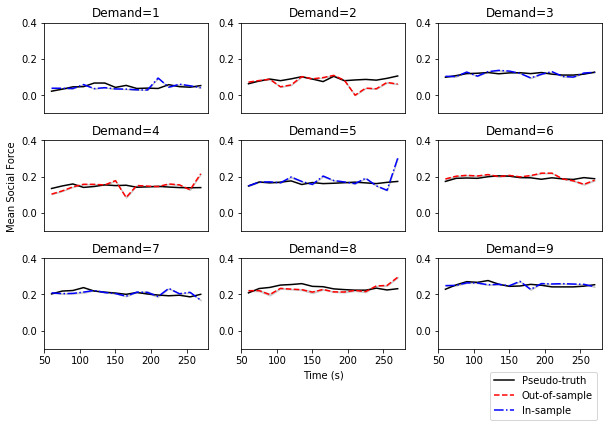

In [175]:
# Main modelling block
fig, axs = plt.subplots(3,3, figsize=(10, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.2)

custom_lines = [Line2D([0], [0], color='k'),
                Line2D([0], [0], color='r', ls = '--'),
                Line2D([0], [0], color='b', ls = '-.')]

axs = axs.ravel()
#import forestci as fci
pred_results = []
y_test_list = []
for i in range(1,10):
    #load testing data
    #print(i)
    filename = './data/val-'+ str(i) +'ped.csv'
    #print(filename)
    test_data = np.genfromtxt(filename, delimiter=',')
    #print(test_data)
    test_data = test_data[test_data[:,0]>minT]
    #x: flow in at each `check point', or `cell': x_i^t
    #y: mean_speed,std_speed,mean_xforce,std_xforce
    x_test = test_data[:-1,(0,1,3,5,7,9,11,13,15,17)]
    X_test = sc.transform(x_test)
    y_test=test_data[1:,19]
    
    #make predictions using the trained model
    y_pred, y_unc, _ = gp2.predict(X_test,do_unc=True, do_deriv=False)
    #plotting
    
    axs[i-1].plot(range(minT+timeStep,maxT,timeStep),y_test,'k-',label='Testing data')
    axs[i-1].set_title('Demand='+ str(i))
    axs[i-1].fill_between(range(minT+timeStep,maxT,timeStep), y_pred-2.96*y_unc,y_pred+2.96*y_unc, color="0.8")
    
    if (i<7):
        axs[i-1].get_xaxis().set_visible(False)
    if (i % 2)==1:
        #axs[i-1].set_ylim(-0.1, 0.1)
        axs[i-1].plot(range(minT+timeStep,maxT,timeStep),y_pred,'b-.',label='In-sample ')
    else: axs[i-1].plot(range(minT+timeStep,maxT,timeStep),y_pred,'r--',label='Out-of-sample ')
    
    if (i==4):
        axs[i-1].set_ylabel('Mean Social Force')
    
    if (i==8):
        axs[i-1].set_xlabel('Time (s)')
        axs[-1].legend(custom_lines, ['Pseudo-truth', 'Out-of-sample', 'In-sample'],bbox_to_anchor=(1, -0.2))
        #legend = axs[i-1].legend(loc='lower outside')
                
    axs[i-1].set_ylim(-0.1, 0.4)
    #Save to the overall storage
    pred_results.append(y_pred)
    y_test_list.append(y_test)

pred_results=np.hstack(pred_results)
y_test_list=np.hstack(y_test_list)

plt.savefig('Figures/Short-term-GP-more-training.pdf')
plt.show()    
#print(pred_results)
#print(y_test_list)

In [176]:
# Main modelling block
#import forestci as fci
pred_results_SEEN = []
y_test_list_SEEN = []
for i in range(1,11,2):
    #load testing data
    #print(i)
    filename = './data/val-'+ str(i) +'ped.csv'
    #print(filename)
    test_data = np.genfromtxt(filename, delimiter=',')
    #print(test_data)
    test_data = test_data[test_data[:,0]>minT]
    #x: flow in at each `check point', or `cell': x_i^t
    #y: mean_speed,std_speed,mean_xforce,std_xforce
    x_test = test_data[:-1,(0,1,3,5,7,9,11,13,15,17)]
    X_test = sc.transform(x_test)
    y_test=test_data[1:,19]
    
    #make predictions using the trained model
    y_pred, y_unc, _ = gp2.predict(X_test,do_unc=True, do_deriv=False)
    pred_results_SEEN.append(y_pred)
    y_test_list_SEEN.append(y_test) 

#pred_results_SEEN=np.hstack(pred_results_SEEN)
#y_test_list_SEEN = np.hstack(y_test_list_SEEN)


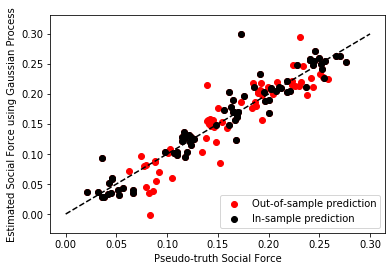

In [177]:

# Plot predicted MPG without error bars
plt.scatter(y_test_list, pred_results,c='red',label='Out-of-sample prediction')

plt.scatter(y_test_list_SEEN, pred_results_SEEN,c='black',label='In-sample prediction')


plt.plot([0, 0.3], [0, 0.3], 'k--')
plt.legend(loc='lower right')
plt.xlabel('Pseudo-truth Social Force')
plt.ylabel('Estimated Social Force using Gaussian Process')
#plt.savefig('NHPP_aggregated_same.pdf')
plt.savefig('Figures/Short-term-GP-more-training-scatterplot.pdf')
plt.show()